# ALGORISME SEGMENTACIO MATRICULA

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import argparse

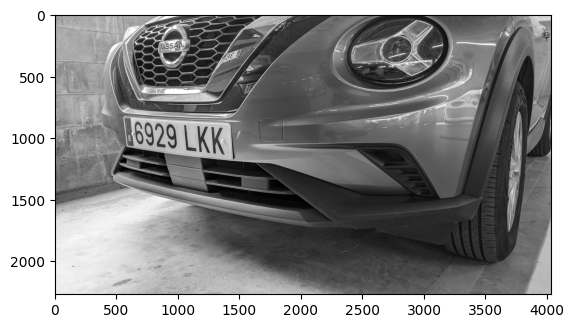

In [18]:
#llegir imatge i mostrar
base= "/Users/carlotacortes/Desktop/PSIV/fotosmatricukes" #directori charli
image = cv2.imread(f"{base}/imagen4.jpg")
image_original = image.copy()
#convert to grayscale per després
grayimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(grayimg, cmap="gray")
plt.show()

### BLACKHAT

The license plate is bright since it’s a white region against a dark background of the car itself. An excellent starting point to finding the region of a license plate would be to use the top hat operator.
A top hat operation is used to reveal bright regions of an image on dark backgrounds.

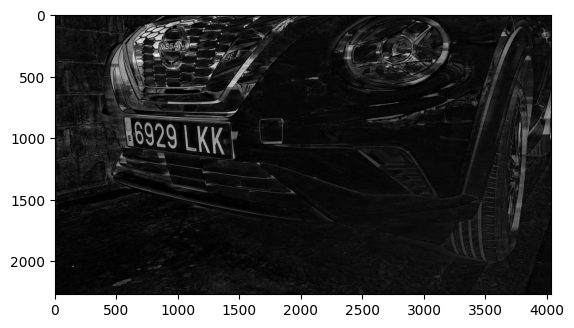

In [19]:
##definir un rectangular structuring element (kernel) with w=13, h=5.
##aquests numeros perque normalment una matricula es 3 vegades w del h.
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13,5))
#find dark regions on a light blackground
blackhat = cv2.morphologyEx(grayimg, cv2.MORPH_BLACKHAT, rectKernel, iterations=5)
#find light regions on a dark background
#tophat = cv2.morphologyEx(grayimg, cv2.MORPH_TOPHAT, rectKernel, iterations=10)

plt.imshow(blackhat, cmap="gray")
#plt.imshow(tophat, cmap="gray")
plt.show()

### Scharr gradient + normalization

The Scharr gradient will detect edges in the image and emphasize the boundaries of the characters in the license plate.

Using cv2.Sobel, we compute the Scharr gradient magnitude representation in the x-direction of our blackhat image. We then scale the resulting intensities back to the range [0, 255]

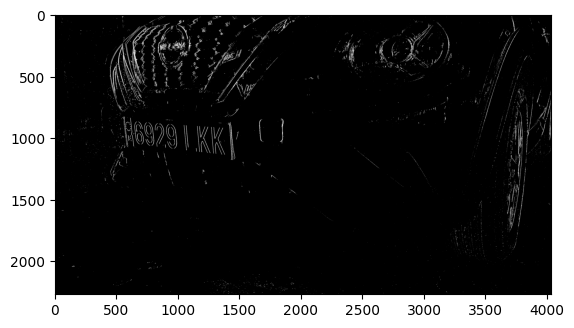

In [20]:
gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1,dy=0, ksize=-1)

gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal))).astype("uint8")
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) [1]
plt.imshow(thresh, cmap="gray")
plt.show()
thresh_original = thresh.copy()



### FIND REGIONS THAT ARE LIGHT: CLOSE AND THRESHOLD

blur the gradient representation = closing.

then threshold the image using OTsu's method

Using a small square kernel, we apply a closing operation to fill small holes and help us identify larger structures in the image.
Then perform binary threshold (automatic method=OTSU) per revelar the light regions que poden contenir els numeros

THRESHOLDING: It allows us to separate the foreground (what we are interested) from the background.
IT IS A BINARIZATION OF AN IMAGE !!!
SEEK to converge grayscale image to a binary image (pixels are 0 or 255). On requereix una T per com limit decisio.

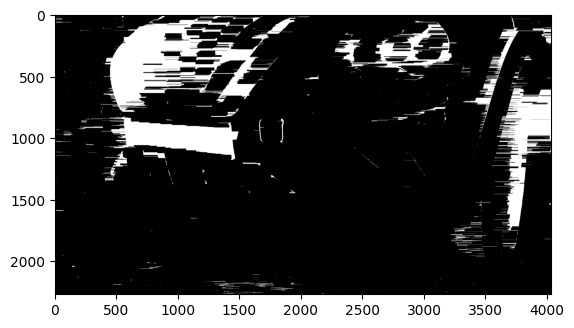

In [21]:
#blur
gradX = cv2.GaussianBlur(thresh_original, (5, 5), 0)
#close
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) [1]
squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 1))
gradX = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, squareKern, iterations=10)

plt.imshow(gradX, cmap="gray")
plt.show()

### FER OPEN PER TREURE LES LINEES FINES 

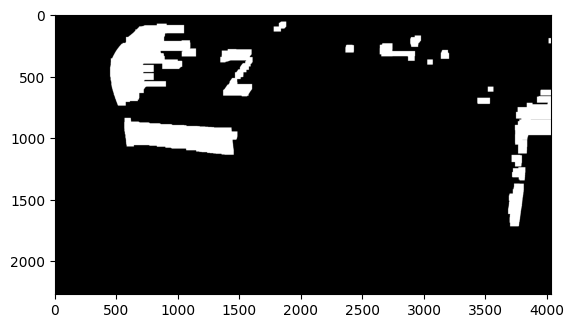

In [22]:
squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
gradX = cv2.morphologyEx(gradX, cv2.MORPH_OPEN, squareKern, iterations=10)
plt.imshow(gradX, cmap="gray")
plt.show()

### TROBAR ELS CONTOURS

Function findContours() per detectar els contours de la imatge gradX. Contours són les curves juntat tots els punts continus tenint el mateix color o intensitat. 
RETR_TREE: treu tots els contours i reconstrueix una jerarquia amb els contours.
CHAIN_APPROX_SIMPLE: treu tots els punts redundants  

In [23]:
contours, hierarchy = cv2.findContours(gradX, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

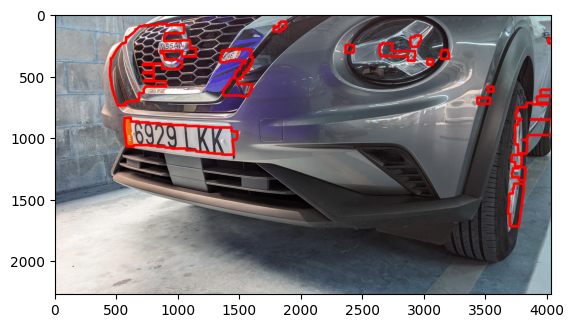

In [24]:
#dibuixa tots els contoursv detectats
#-1 per dibuixar tots els trobats
#20= amplada de la linea a mostrar del contour
img = cv2.drawContours(image, contours, -1, (255,0 , 0), 20)
plt.imshow(img)

### loop over the contours and draw them seperately

cv2.boundingRect(contour): Computes el rectangle més petit que pot lligar el contour.  
x, y: Top-left corner.
w, h: Width and height of the rectangle.

area = cv2.contourArea(contour): calcula l'area de cada contour

Amb el loop itera entre tots els contours i selecciona amb el max_area. Pero tenint en compte que tingui un ratio de rectangle w/h entre 2-5. 

In [25]:
# get the contour with the biggest area and the rectangle around it has a ratio similar of 5:1
max_area = 0
biggest_contour = None
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    area = cv2.contourArea(contour)
    if area > max_area and w / h > 2.0 and w / h < 5.0:
        max_area = area
        biggest_contour = contour


### Draw rectangle en el contour amb max_area

fer servir cv2.rectangle

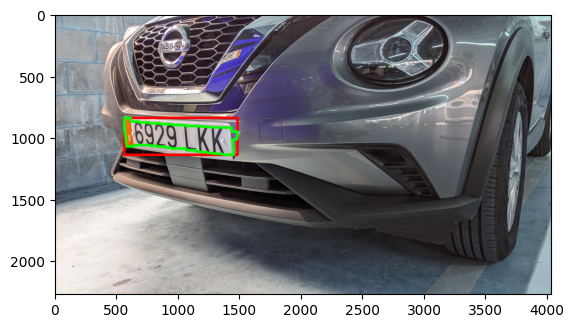

In [26]:
# draw rectangle around the biggest contour!!!
image = image_original.copy()
#trobar els punts que el defineixen
x, y, w, h = cv2.boundingRect(biggest_contour)
cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 20)
# draw the biggest contour
cv2.drawContours(image, [biggest_contour], -1, (0, 255, 0), 20)
plt.imshow(image)

### Aproximar la shape

epsilon = 0.02 * perimeter: approximation accuracy

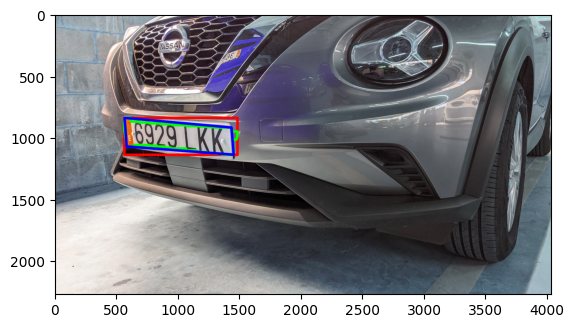

In [27]:
#calcular el perimetre de biggest_contour
#true és que el contour esta tancat
epsilon = 0.02 * cv2.arcLength(biggest_contour, True)  # Adjust this value if needed
#aproxima el contour a altres punts depenent del valor 
approx = cv2.approxPolyDP(biggest_contour, epsilon, True)
cv2.drawContours(image, [approx], -1, (0, 0, 255), 20)
plt.imshow(image)



### Retallar el ROI (region of interest)

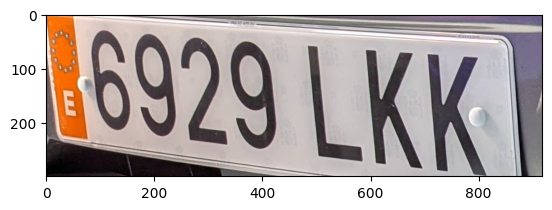

In [28]:
# transform the original image using the rectangle coordinates
roi = image_original[y:y+h, x:x+w]
plt.imshow(roi)

### Transformacio de la perspectiva

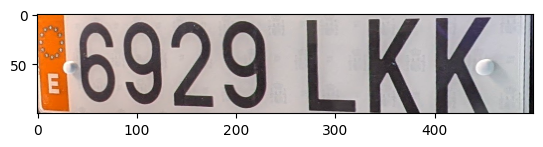

In [29]:
pts_src = approx.reshape(4, 2) #reshape a una matriu 4x2 representant els corners del rectangle
#els quatre punts son ordenats amb un ordre especific 
# fent servir sum i diff per identificar les coordenades basades en les relacions geometriques
s = pts_src.sum(axis=1)
diff = np.diff(pts_src, axis=1)
rect = np.zeros((4, 2), dtype="float32")

#top-left, top-right, bottom-right, bottom-left)
rect[0] = pts_src[np.argmin(s)]
rect[2] = pts_src[np.argmax(s)]
rect[1] = pts_src[np.argmin(diff)]
rect[3] = pts_src[np.argmax(diff)]

#defineix els punts per la transformació de la perspectiva creant una nova w i h 
width, height = 500, 100
pts_dst = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

#computa la transformacio de perspectiva amb M que mapea les coordiandes del rect
M = cv2.getPerspectiveTransform(rect, pts_dst)
#aplica la tranformacio
#warped_image es la transformed image
warped_image = cv2.warpPerspective(image_original, M, (width, height))

plt.imshow(warped_image)
plt.show()